In [1]:
%matplotlib inline
import random
import torch
import copy
import torchvision
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from keras.datasets import mnist
from gudhi.wasserstein import wasserstein_distance
from torchvision import transforms as T

/Users/rafaeldks/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img, cmap='gray')

In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

## Задание параметра шума

In [4]:
noise = 'topological'
# noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [5]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

In [6]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:60000
No of Test datapoints:10000


## Нанесение шума

In [7]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [8]:
noise_ct = 0
noise_id = 0
testdata = np.zeros((1000, 28, 28))

for idx in tqdm(range(1000)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 1000/1000 [00:00<00:00, 7038.28it/s]


topological noise addition completed to images


In [9]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [10]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

testset=noisedDataset(testdata,xtest,ytest,tsfms)

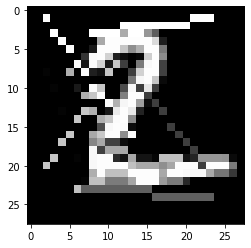

In [11]:
# Смотрим на пример зашумлённого изображения
plot(testdata[1])

## Объявление функций потерь

In [12]:
# Функция для получения диаграммы устойчивости изображения
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [13]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [14]:
mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

## Тестирование моделей

In [15]:
batch_size = 64
dataloader_test = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
for i in range(1,4):
    model = Autoencoder(28*28, 32)
    # Здесь нужно указать путь к файлам с моделями
    model.load_state_dict(torch.load(f"/Users/rafaeldks/Desktop/MyProject/Topological/custom_model_{i}.pt"))
    mse_loss_epoch = []
    topo_loss_epoch = []

    for X, y, label in tqdm(dataloader_test):
        X=X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
        y=y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
        mse_loss_batch = mse_loss_fn(model(X), y)
        topo_loss_batch = topo_loss_fn(model(X), y)
        
        mse_loss_epoch.append(mse_loss_batch.detach())
        topo_loss_epoch.append(topo_loss_batch.detach()) 
        
mse_loss_mean = np.mean(mse_loss_epoch)
topo_loss_mean = np.mean(topo_loss_epoch)
print('MSE Loss', 'Topo Loss')
print(mse_loss_mean, topo_loss_mean)

100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

MSE Loss Topo Loss
5330.2656 602.704
